In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.linalg import lstsq
import scipy.optimize as opt
from tqdm.notebook import tqdm

sns.set(color_codes=True)
mpl.rcParams['figure.dpi'] = 120

In [2]:
df1 = pd.read_csv('Канал 1_500nm_2mm.csv', delimiter=';')
df1.columns = ['мВ', 'мА']
df2 = pd.read_csv('Канал 2_500nm_2mm.csv', delimiter=';')
df2.columns = ['мВ', 'мА']

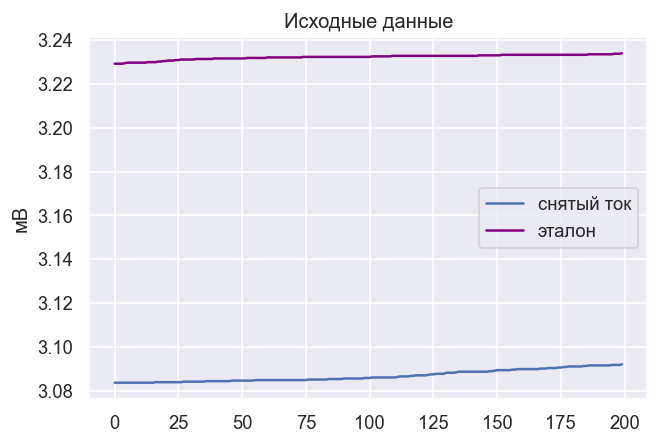

In [4]:
plt.title('Исходные данные')

plt.plot(df1['мВ'], label='снятый ток', color='b')
plt.plot(df2['мВ'], label='эталон', color='purple')
plt.legend()
plt.ylabel('мВ')
plt.show()

In [5]:
eps = 1e-4

In [6]:
df1['infV'] = df1['мВ'] - eps
df1['supV'] = df1['мВ'] + eps

df2['infV'] = df2['мВ'] - eps
df2['supV'] = df2['мВ'] + eps

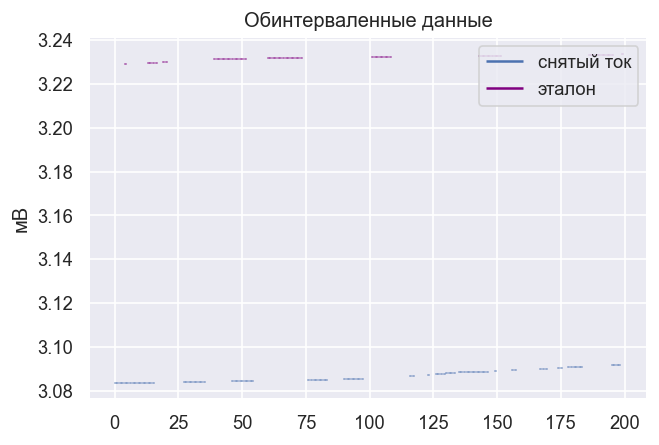

In [7]:
plt.title('Обинтерваленные данные')

plt.vlines(np.arange(len(df1)), df1['infV'], df1['supV'], label='снятый ток', colors='b')
plt.vlines(np.arange(len(df2)), df2['infV'], df2['supV'], label='эталон', colors='purple')

plt.legend()
plt.ylabel('мВ')

plt.show()

In [8]:
borders = [0, 25, 175, 200]

In [9]:
x = np.arange(len(df1))
A = np.vstack([x, np.ones(len(x))]).T

In [13]:
sol1 = []
for l, r in zip(borders[:-1], borders[1:]):
    print(str(l) + " " + str(r) + "\n")
    sol1.append(lstsq(A[l:r], df1['мВ'].iloc[l:r])[0])
    
sol2 = []
for l, r in zip(borders[:-1], borders[1:]):
    print(str(l) + " " + str(r) + "\n")
    sol2.append(lstsq(A[l:r], df2['мВ'].iloc[l:r])[0])

sol2


0 25

25 175

175 200

0 25

25 175

175 200



C:\Users\rafan\AppData\Local\Temp\ipykernel_10792\926687269.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol1.append(lstsq(A[l:r], df1['мВ'].iloc[l:r])[0])
C:\Users\rafan\AppData\Local\Temp\ipykernel_10792\926687269.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol2.append(lstsq(A[l:r], df2['мВ'].iloc[l:r])[0])


[array([6.40107692e-05, 3.22907463e+00]),
 array([1.40770328e-05, 3.23095337e+00]),
 array([2.40515385e-05, 3.22889284e+00])]

In [14]:
mnk1 = []
for sol, l, r in zip(sol1, borders[:-1], borders[1:]):
    mnk1.extend(sol[0] * x[l:r] + sol[1])
    
mnk2 = []
for sol, l, r in zip(sol2, borders[:-1], borders[1:]):
    mnk2.extend(sol[0] * x[l:r] + sol[1])

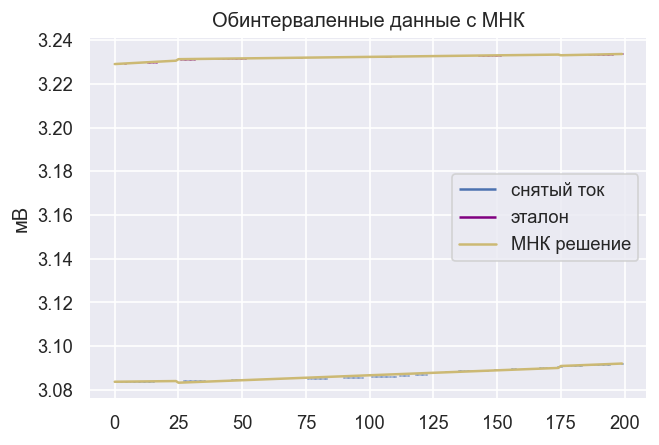

In [15]:
plt.title('Обинтерваленные данные с МНК')

plt.vlines(np.arange(len(df1)), df1['infV'], df1['supV'], label='снятый ток', colors='b')
plt.plot(x, mnk1, c='y')

plt.vlines(np.arange(len(df2)), df2['infV'], df2['supV'], label='эталон', colors='purple')
plt.plot(x, mnk2, c='y' ,label='МНК решение')

plt.ylabel('мВ')
plt.legend()

plt.show()

In [16]:
w1 = []
for pred, tg in zip(mnk1, df1['мВ']):
    w1.append(max(abs(pred-tg) / eps, 1))
w1 = np.array(w1)

w2 = []
for pred, tg in zip(mnk2, df2['мВ']):
    w2.append(max(abs(pred-tg) / eps, 1))
w2 = np.array(w2)

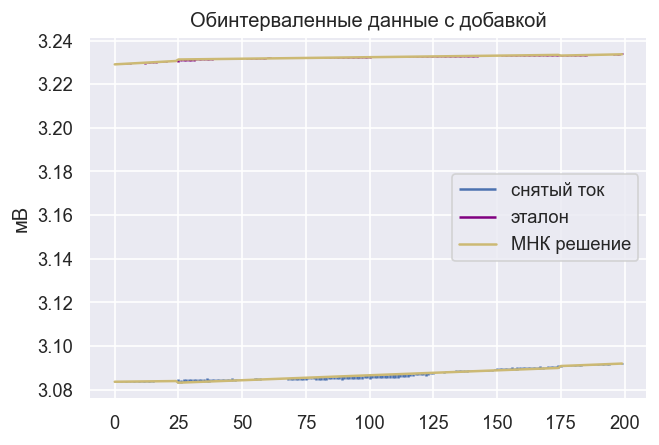

In [17]:
plt.title('Обинтерваленные данные с добавкой')

plt.vlines(x, df1['мВ']-[i*eps for i in w1], df1['мВ']+[i*eps for i in w1], label='снятый ток', colors='b')
plt.plot(x, mnk1, c='y')

plt.vlines(x, df2['мВ']-[i*eps for i in w2], df2['мВ']+[i*eps for i in w2], label='эталон', colors='purple')
plt.plot(x, mnk2, c='y',label='МНК решение')

plt.ylabel('мВ')
plt.legend()

plt.show()

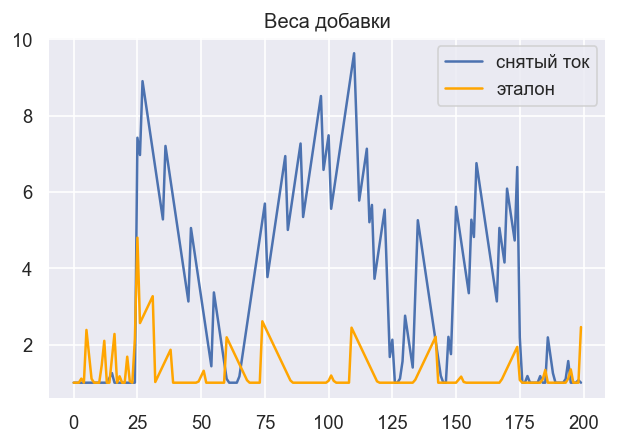

In [18]:
plt.title('Веса добавки')
plt.plot(w1, label='снятый ток', color='b')
plt.plot(w2, label='эталон', color='orange')
plt.legend()

plt.show()

In [19]:
new_rad1 = max(w1) * eps
new_rad2 = max(w2) * eps

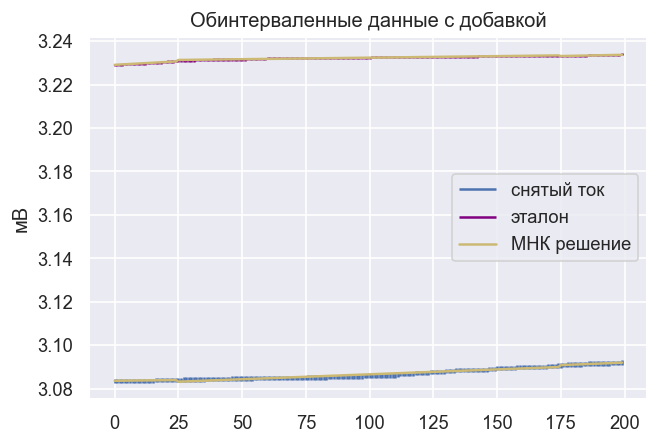

In [20]:
plt.title('Обинтерваленные данные с добавкой')

plt.vlines(x, df1['мВ']-new_rad1, df1['мВ']+new_rad1, label='снятый ток', colors='b')
plt.plot(x, mnk1, c='y')

plt.vlines(x, df2['мВ']-new_rad2, df2['мВ']+new_rad2, label='эталон', colors='purple')
plt.plot(x, mnk2, c='y',label='МНК решение')

plt.ylabel('мВ')
plt.legend()

plt.show()

In [23]:
def get_info(data, rad, x):
    data = data[borders[1]: borders[2]]
    x0 = x[borders[1]]
    x_new = np.arange(borders[2] - borders[1])
    x = x[borders[1]:borders[2]]
    bt = []
    bt_up = []
    bt_down = []
    for b in tqdm(np.arange(data[0] - rad, data[0] + rad, 1e-6)):
        for i in range(1, len(data)):
            k = (data[i] - rad - b) / i
            y = b + k * x_new
            if ((data - rad) <= y).all() and ((data + rad) >= y).all():
                bt.append([b-k*x0, k])
                bt_down.append([b-k*x0, k])

            k = (data[i] + rad - b) / i
            y = b + k * x_new
            if ((data - rad) <= y).all() and ((data + rad) >= y).all():
                bt.append([b-k*x0, k])
                bt_up.append([b-k*x0, k])
                
    bt = np.array(bt)
    
    bt_down.sort()
    bt_up.sort()
    
    # btdf = pd.DataFrame(bt).groupby(0).agg(list).reset_index()
    b0 = list(np.array(bt_down)[:, 0]) + list(np.array(bt_up)[:, 0][::-1])
    #b1 = np.array(btdf[1].tolist())
    b1 = list(np.array(bt_down)[:, 1]) + list(np.array(bt_up)[:, 1][::-1])
    
    x_ptp = bt[:, 0].max() - bt[:, 0].min()
    y_ptp = bt[:, 1].max() - bt[:, 1].min()
    
    plt.title('Информационное множество')
    plt.xlim(bt[:, 0].min() - x_ptp * 0.1, bt[:, 0].max() + x_ptp * 0.1)
    plt.ylim(bt[:, 1].min() - y_ptp * 0.1, bt[:, 1].max() + y_ptp * 0.1)
    axes = plt.gca()

    axes.add_patch(mpl.patches.Polygon(np.array([b0, b1]).T, color='pink'))

    axes.add_patch(mpl.patches.Polygon(
        [(bt[:, 0].min(), bt[:, 1].min()),
         (bt[:, 0].min(), bt[:, 1].max()),
         (bt[:, 0].max(), bt[:, 1].max()),
         (bt[:, 0].max(), bt[:, 1].min())], 
        color='r', 
        fill=False
    ))

    plt.xlabel('\u03B20')
    plt.ylabel('\u03B21')
    plt.show()
    
    bbox = []
    for i in x:
        bbox.append([row[0] + i * row[1] for row in bt])

    bbox = np.array(bbox)
    
    plt.title('Диаграмма рассеяния и коридор совместности')
    plt.vlines(x, data-rad, data+rad, label='снятый ток', colors='b')

    axes = plt.gca()

    axes.add_patch(mpl.patches.Polygon(np.array([list(x) + list(x[::-1]), list(bbox.max(axis=1)) + list(bbox.min(axis=1)[::-1])]).T,
                                              color='g',
                                              alpha=0.5,
                                              zorder=3))
    
    return bt

  0%|          | 0/1928 [00:00<?, ?it/s]

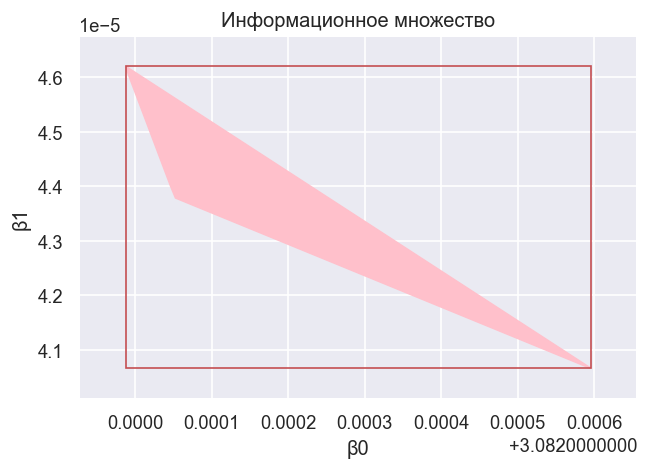

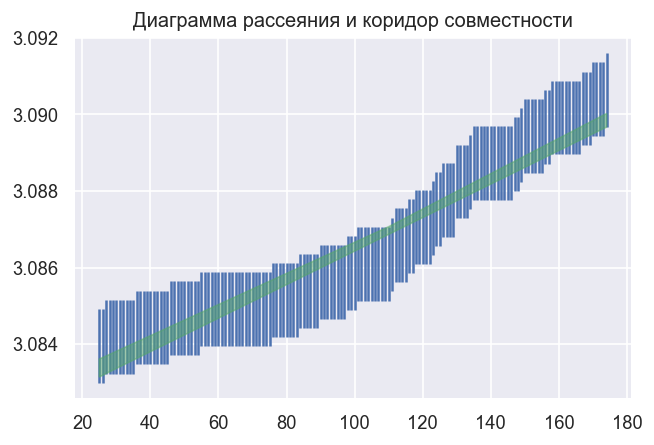

In [24]:
bt1 = get_info(df1['мВ'].tolist(), new_rad1, x)

  0%|          | 0/961 [00:00<?, ?it/s]

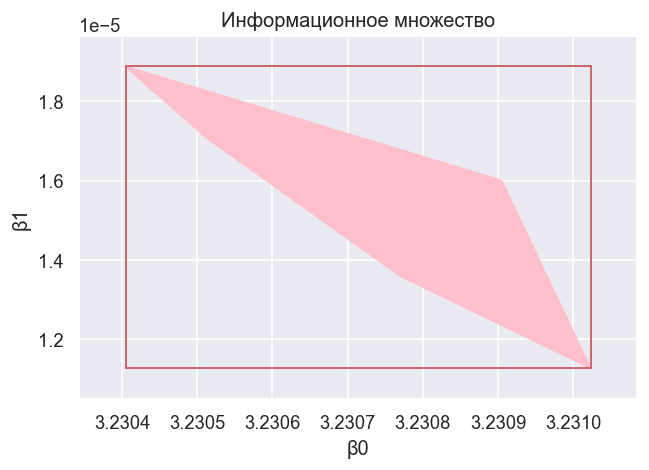

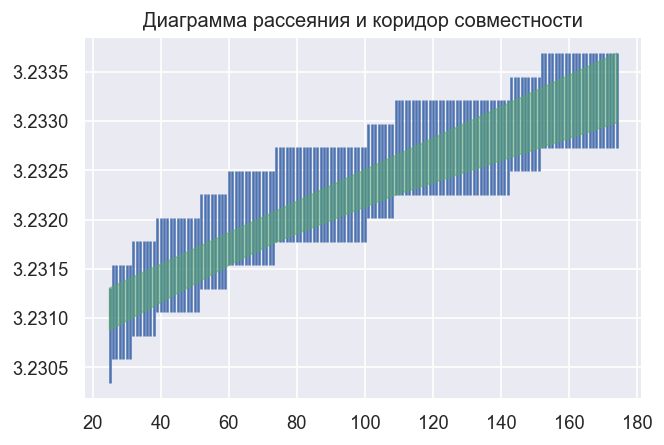

In [25]:
bt2 = get_info(df2['мВ'].tolist(), new_rad2, x)

In [26]:
def plot_predict(data, bt, x, borders):
    bbox = []
    x_osn = x[borders[1]: borders[2]]
    for i in x_osn:
        bbox.append([row[0] + i * row[1] for row in bt])

    bbox = np.array(bbox)
    
    d_max_otr = bbox.max(axis=1)[1] - bbox.max(axis=1)[0]
    d_max_pos = bbox.max(axis=1)[-1] - bbox.max(axis=1)[-2]
    d_min_otr = bbox.min(axis=1)[1] - bbox.min(axis=1)[0]
    d_min_pos = bbox.min(axis=1)[-1] - bbox.min(axis=1)[-2]

    x_otr = []
    y_otr = []
    for i, j in enumerate(np.arange(borders[1]-1, borders[0]-1, -1)):
        x_otr.append(j)
        y_otr.append(bbox.max(axis=1)[0] - d_max_otr*(i+1))

    for i, j in enumerate(np.arange(borders[0], borders[1])):
        x_otr.append(j)
        y_otr.append(bbox.min(axis=1)[0] - d_min_otr*(borders[1]-i))

    x_pos = []
    y_pos = []
    for i, j in enumerate(np.arange(borders[2], borders[3])):
        x_pos.append(j)
        y_pos.append(bbox.max(axis=1)[-1] + d_max_pos*(i+1))
    lag = borders[3] - borders[2]
    for i, j in enumerate(np.arange(borders[3]-1, borders[2]-1, -1)):
        x_pos.append(j)
        y_pos.append(bbox.min(axis=1)[-1] + d_min_pos*(lag-i))
        
    plt.title('Диаграмма рассеяния и коридор совместности внутри и вне интервала имеющихся данных')
    plt.vlines(x, data[0], data[1], label='снятый ток', colors='b')

    axes = plt.gca()

    axes.add_patch(mpl.patches.Polygon(np.array([list(x_osn) + list(x_osn[::-1]), list(bbox.max(axis=1)) + list(bbox.min(axis=1)[::-1])]).T,
                                              color='y',
                                              alpha=0.6,
                                              zorder=3))

    axes.add_patch(mpl.patches.Polygon(np.array([x_otr, y_otr]).T,
                                              color='r',
                                              alpha=0.6,
                                              zorder=3))

    axes.add_patch(mpl.patches.Polygon(np.array([x_pos, y_pos]).T,
                                              color='r',
                                              alpha=0.6,
                                              zorder=3))
    
    plt.show()
    
    otr = [y_otr[len(y_otr)//2:], y_otr[:len(y_otr)//2][::-1]]
    pos = [y_pos[len(y_pos)//2:][::-1], y_pos[:len(y_pos)//2]]
    osn = [list(bbox.min(axis=1)), list(bbox.max(axis=1))]
    
    return otr, osn, pos

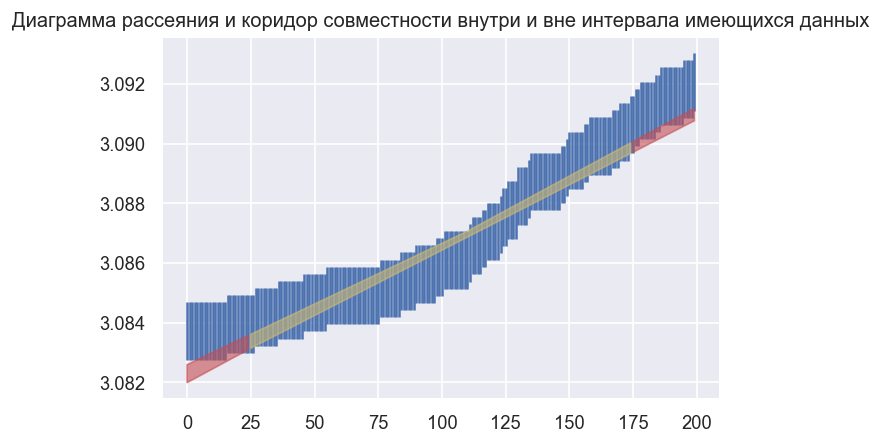

In [27]:
plot_predict([(df1['мВ'] - new_rad1).tolist(), (df1['мВ'] + new_rad1).tolist()], bt1, x, borders);

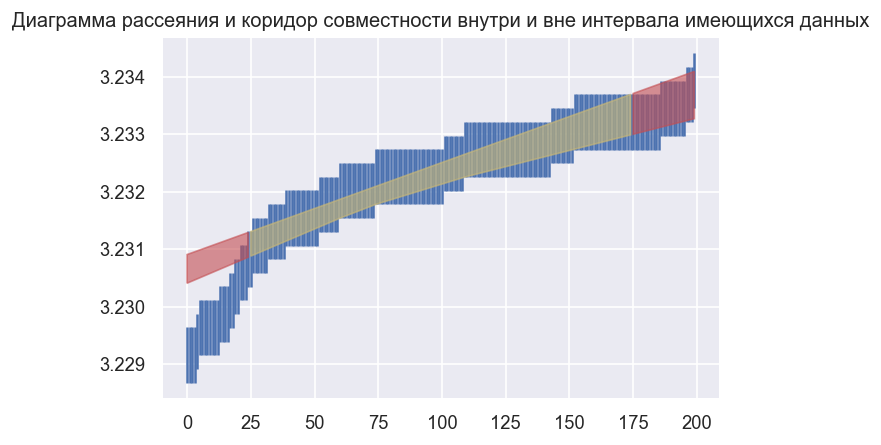

In [28]:
plot_predict([(df2['мВ'] - new_rad2).tolist(), (df2['мВ'] + new_rad2).tolist()], bt2, x, borders);

In [29]:
h_mnk1 = mnk1 - sol1[1][1]
h_mnk2 = mnk2 - sol2[1][1]

In [30]:
df1['infI'] = df1['мВ'] - new_rad1 - h_mnk1
df1['supI'] = df1['мВ'] + new_rad1 - h_mnk1

df2['infI'] = df2['мВ'] - new_rad2 - h_mnk2
df2['supI'] = df2['мВ'] + new_rad2 - h_mnk2

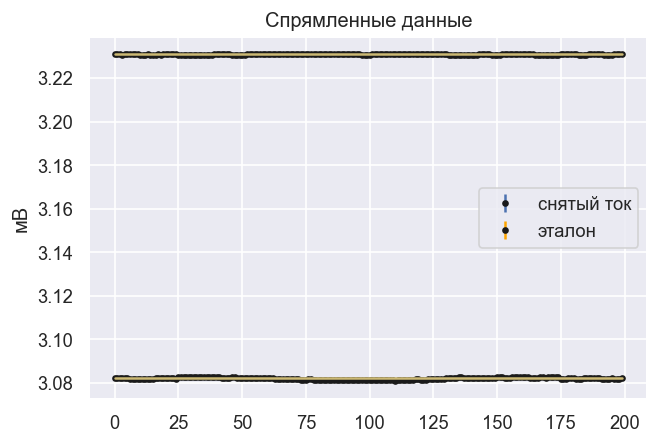

In [31]:
plt.title('Спрямленные данные')

plt.errorbar(x, df1["мВ"] - h_mnk1, yerr=[i*eps for i in w1], c='k', ecolor='b', marker='o', ms=3, linestyle='none', label='снятый ток')
plt.errorbar(x, df2["мВ"] - h_mnk2, yerr=[i*eps for i in w2], c='k', ecolor='orange', marker='o', ms=3, linestyle='none', label='эталон')

plt.plot(x, [sol1[1][1] for _ in x], c='y', zorder=3)

plt.plot(x, [sol2[1][1] for _ in x], c='y', zorder=3)

plt.ylabel('мВ')
plt.legend()

plt.show()

  0%|          | 0/1928 [00:00<?, ?it/s]

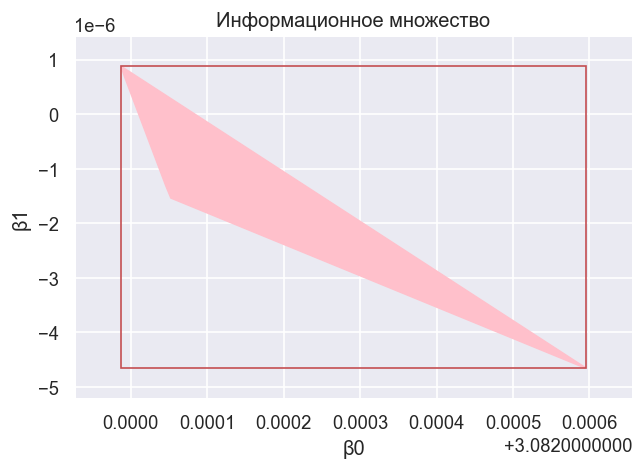

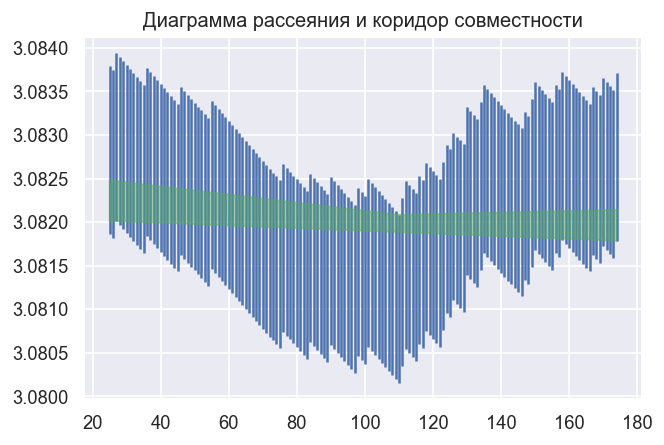

In [32]:
bt11 = get_info((df1['мВ']- h_mnk1).tolist(), new_rad1, x);

  0%|          | 0/961 [00:00<?, ?it/s]

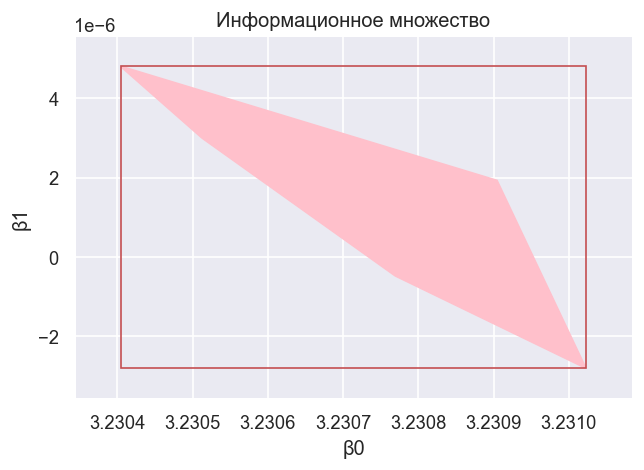

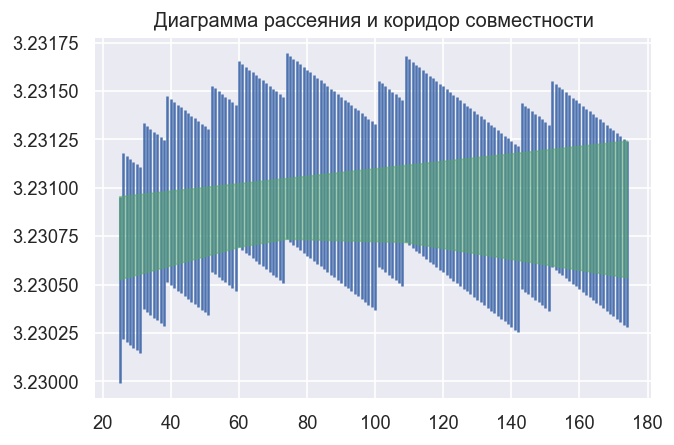

In [33]:
bt21 = get_info((df2['мВ']- h_mnk2).tolist(), new_rad2, x);

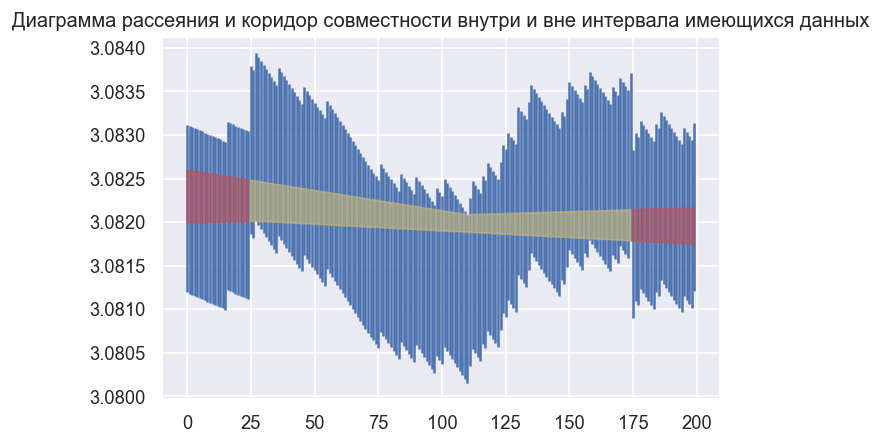

In [34]:
ost1 = plot_predict([(df1['мВ'] - new_rad1 - h_mnk1).tolist(), (df1['мВ'] + new_rad1 - h_mnk1).tolist()], bt11, x, borders)

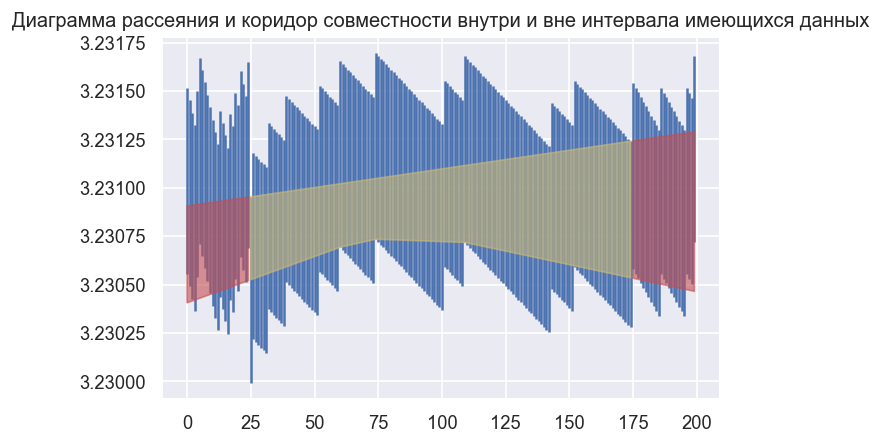

In [35]:
ost2 = plot_predict([(df2['мВ'] - new_rad2 - h_mnk2).tolist(), (df2['мВ'] + new_rad2 - h_mnk2).tolist()], bt21, x, borders)

In [36]:
ost1 = np.array([ost1[0][0] + ost1[1][0] + ost1[2][0], ost1[0][1] + ost1[1][1] + ost1[2][1]])
ost2 = np.array([ost2[0][0] + ost2[1][0] + ost2[2][0], ost2[0][1] + ost2[1][1] + ost2[2][1]])

In [37]:
r1 = ((df1['мВ'] - h_mnk1 - ost1.mean(axis=0)) / new_rad1).to_numpy()
r2 = ((df2['мВ'] - h_mnk2 - ost2.mean(axis=0)) / new_rad2).to_numpy()

In [38]:
l1 = (ost1[1] - ost1[0]) / 2 / new_rad1
l2 = (ost2[1] - ost2[0]) / 2 / new_rad2

In [42]:
print(new_rad1)
print(new_rad2)

0.000963899978960292
0.00048029439293628684


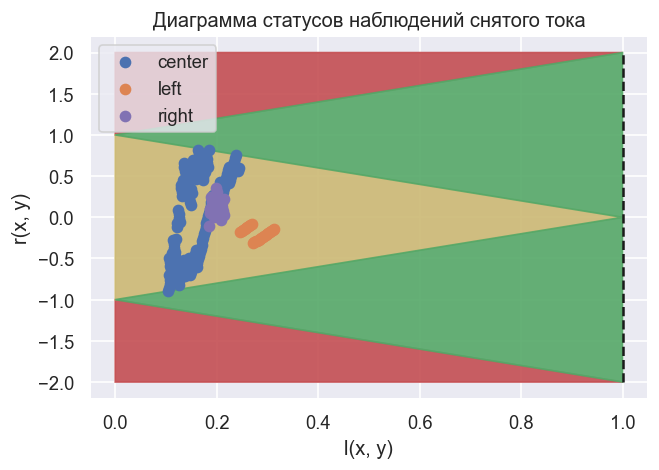

In [46]:
plt.title('Диаграмма статусов наблюдений снятого тока')
plt.scatter(l1[borders[1]: borders[2]], r1[borders[1]: borders[2]], zorder=3, label='center')
plt.scatter(l1[borders[0]: borders[1]], r1[borders[0]: borders[1]], zorder=3, label='left')
plt.scatter(l1[borders[2]: borders[3]], r1[borders[2]: borders[3]], zorder=3, label='right', c='m')
axes = plt.gca()

axes.add_patch(mpl.patches.Polygon(np.array([[0, 0, max(1, l1.max()+0.1)], [-2, -1, -2]]).T,
                                          color='r',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[0, 0, max(1, l1.max()+0.1)], [2, 1, 2]]).T,
                                          color='r',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[0, 1, 0], [-1, 0, 1]]).T,
                                          color='y',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[max(1, l1.max()+0.1), 0, 1, 0, max(1, l1.max()+0.1)], 
                                             [-2, -1, 0, 1, 2]]
                                           ).T,
                                          color='g',
                                          alpha=0.9))

plt.plot([1, 1], [-2, 2], c='k', linestyle='--')

plt.xlabel('l(x, y)')
plt.ylabel('r(x, y)')
plt.legend()
plt.show()

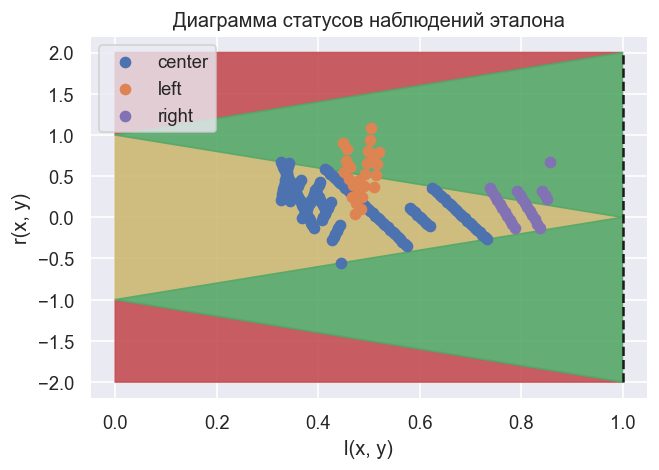

In [41]:
plt.title('Диаграмма статусов наблюдений эталона')
plt.scatter(l2[borders[1]: borders[2]], r2[borders[1]: borders[2]], zorder=3, label='center')
plt.scatter(l2[borders[0]: borders[1]], r2[borders[0]: borders[1]], zorder=3, label='left')
plt.scatter(l2[borders[2]: borders[3]], r2[borders[2]: borders[3]], zorder=3, label='right', c='m')
axes = plt.gca()

axes.add_patch(mpl.patches.Polygon(np.array([[0, 0, max(1, l2.max()+0.1)], [-2, -1, -2]]).T,
                                          color='r',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[0, 0, max(1, l2.max()+0.1)], [2, 1, 2]]).T,
                                          color='r',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[0, 1, 0], [-1, 0, 1]]).T,
                                          color='y',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[max(1, l2.max()+0.1), 0, 1, 0, max(1, l2.max()+0.1)], 
                                             [-2, -1, 0, 1, 2]]
                                           ).T,
                                          color='g',
                                          alpha=0.9))

plt.plot([1, 1], [-2, 2], c='k', linestyle='--')

plt.xlabel('l(x, y)')
plt.ylabel('r(x, y)')
plt.legend()
plt.show()

In [47]:
def JK(sup, inf):
    nom = min(sup) - max(inf)
    denom = max(sup) - min(inf)
    
    return nom / denom

In [48]:
def interval_union(sup, inf):

    merged = np.array([False] * len(sup))
    ch = 0
    while True:

        sup = sup[~merged]
        inf = inf[~merged]
        merged = np.array([False] * len(sup))

        for i in range(len(sup)):
            for j in range(len(sup)):
                if i == j:
                    break
                if (sup[i] >= sup[j]) and (inf[i] <= sup[j]):
                    inf[i] = min(inf[i], inf[j])
                    ch+=1
                    merged[j] = True
                if (sup[i] >= inf[j]) and (inf[i] <= inf[j]):
                    sup[i] = max(sup[i], sup[j])
                    ch+=1
                    merged[j] = True
        if ch == 0:
            break
        else:
            ch=0
            
    return sup, inf


def get_moda(sup, inf):
    r = []
    deletes = []
    for i in sup:
        dl = (inf >= i) | (sup < i)
        deletes.append(dl)
        r.append(dl.sum())

    r = np.array(r)
    f = r == min(r)

    ids = np.where(f)[0]

    inf_moda = []
    for i in ids:
        inf_moda.append(max(inf[(~deletes[i]) & (inf<sup[i])]))

    sup_moda, inf_moda = interval_union(sup[ids], np.array(inf_moda))
    
    width = (sup_moda - inf_moda).sum()

    print('\u222A'.join(['[{}, {}]'.format(np.round(down, 6), np.round(up, 6)) for down, up in zip(inf_moda, sup_moda)]))
    print('Ширина: {}'.format(np.round(width, 6)))
    print(f'Частота: {len(sup) - min(r)}')
    
    return width

0.00048029439293628684
0.0001
<class 'numpy.float64'>
<class 'float'>
<class 'numpy.float64'>


  0%|          | 0/800 [00:00<?, ?it/s]

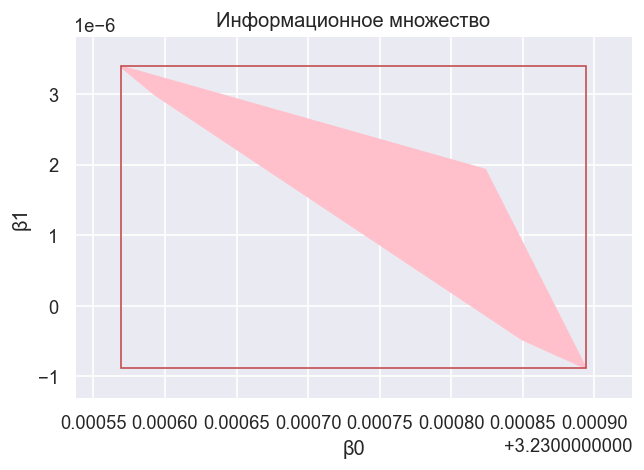

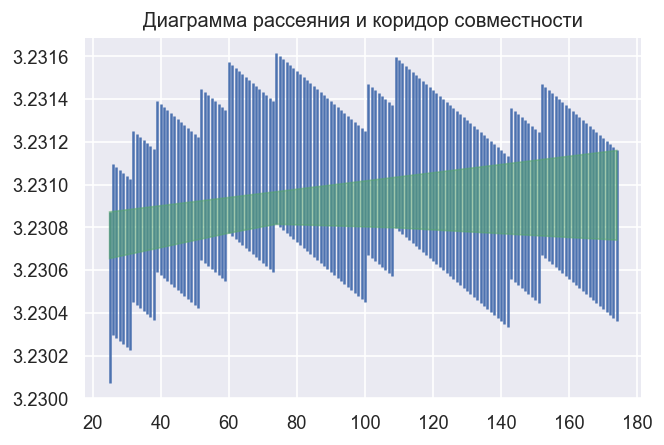

In [49]:
print(new_rad2)
print(1e-4)
print(type(new_rad2))
print(type(2e-4))
rad = np.float64(4e-4)
print(type(rad))
bbbb = get_info((df2['мВ']- h_mnk2).tolist(), rad, x);

In [52]:
ws = []
jks = []

0.0004
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


  0%|          | 0/800 [00:00<?, ?it/s]

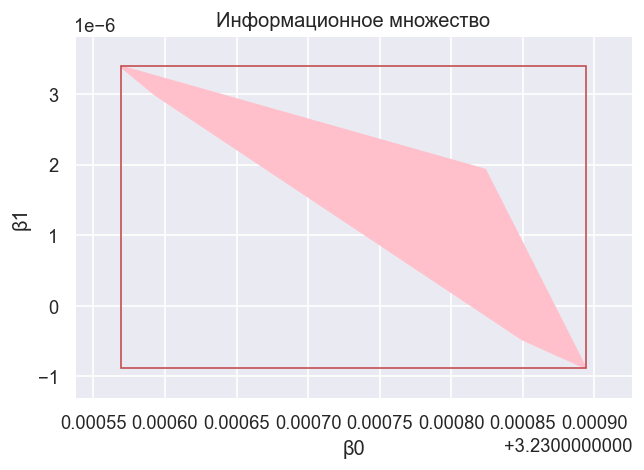

GG


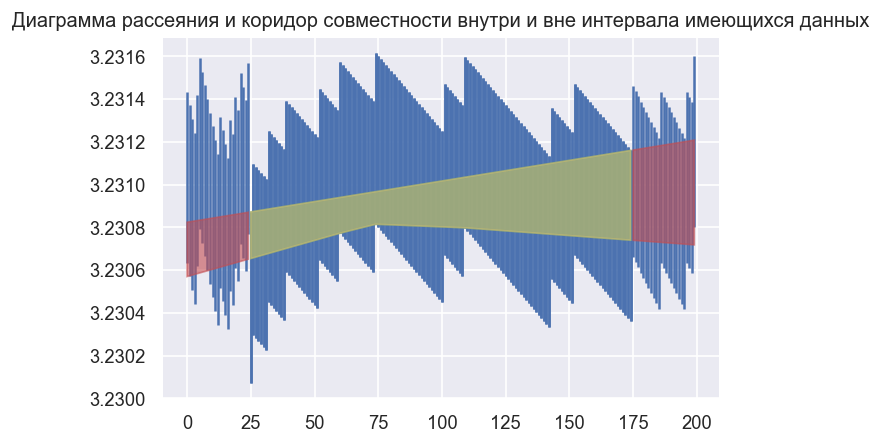

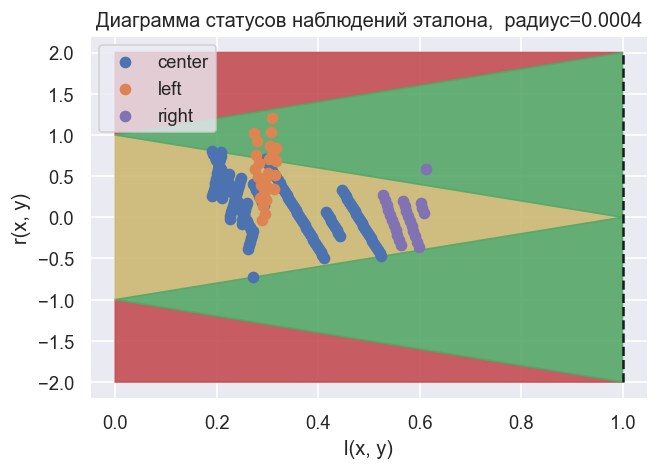

[3.230814, 3.230873]
Ширина: 5.9e-05
Частота: 200
Мера Жаккара: 0.0381
Зеленая зона: 188



In [53]:
# rads = np.arange(1e-4, 3 * 1e-4, 5 * 1e-4, 7 * 1e-4)
rad = np.float64(4e-4)
print(rad)
print(x)


bt = get_info((df2['мВ']- h_mnk2).tolist(), rad, x);

print("GG")

ost = plot_predict([(df2['мВ'] - rad - h_mnk2).tolist(), (df2['мВ'] + rad - h_mnk2).tolist()], bt, x, borders)
ost = np.array([ost[0][0] + ost[1][0] + ost[2][0], ost[0][1] + ost[1][1] + ost[2][1]])

r = ((df2['мВ'] - h_mnk2 - ost.mean(axis=0)) / rad).to_numpy()
l = (ost[1] - ost[0]) / 2 / rad


plt.title(f'Диаграмма статусов наблюдений эталона,  радиус={rad:.4f}')
plt.scatter(l[borders[1]: borders[2]], r[borders[1]: borders[2]], zorder=3, label='center')
plt.scatter(l[borders[0]: borders[1]], r[borders[0]: borders[1]], zorder=3, label='left')
plt.scatter(l[borders[2]: borders[3]], r[borders[2]: borders[3]], zorder=3, label='right', c='m')
axes = plt.gca()

axes.add_patch(mpl.patches.Polygon(np.array([[0, 0, max(1, l.max()+0.1)], [-2, -1, -2]]).T,
                                          color='r',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[0, 0, max(1, l.max()+0.1)], [2, 1, 2]]).T,
                                          color='r',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[0, 1, 0], [-1, 0, 1]]).T,
                                          color='y',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[max(1, l.max()+0.1), 0, 1, 0, max(1, l.max()+0.1)], 
                                             [-2, -1, 0, 1, 2]]
                                           ).T,
                                          color='g',
                                          alpha=0.9))

plt.plot([1, 1], [-2, 2], c='k', linestyle='--')

plt.xlabel('l(x, y)')
plt.ylabel('r(x, y)')
plt.legend()
plt.show()

jk = JK((df2['мВ'] + rad - h_mnk2).to_numpy(), (df2['мВ'] - rad - h_mnk2).to_numpy())
w = get_moda((df2['мВ'] + rad - h_mnk2).to_numpy(), (df2['мВ'] - rad - h_mnk2).to_numpy())

jks.append(jk)
ws.append(w)

print('Мера Жаккара: ' + "{:.4f}".format(jk))


print(f'Зеленая зона: {(np.abs(r) <= 1-l).sum()}')
print()

0.0005
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


  0%|          | 0/1001 [00:00<?, ?it/s]

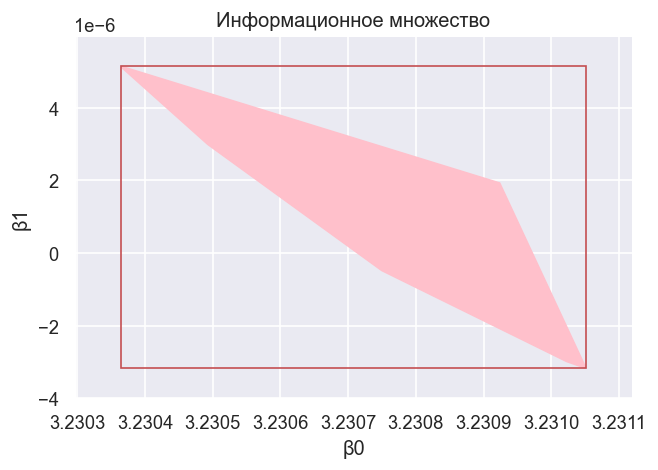

GG


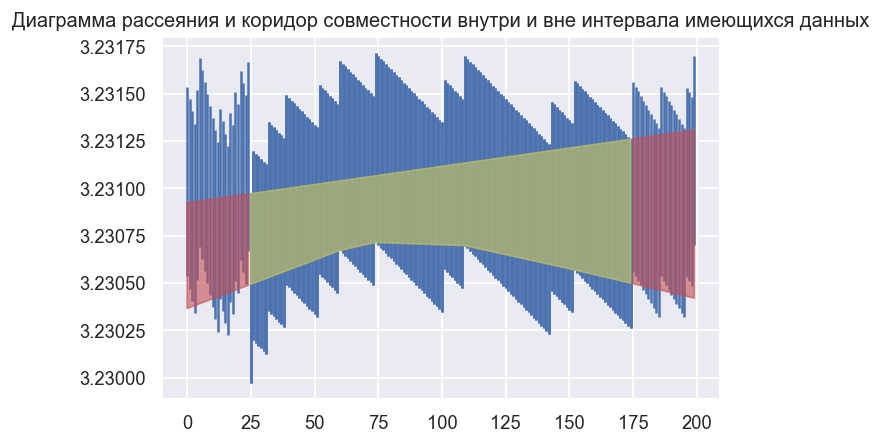

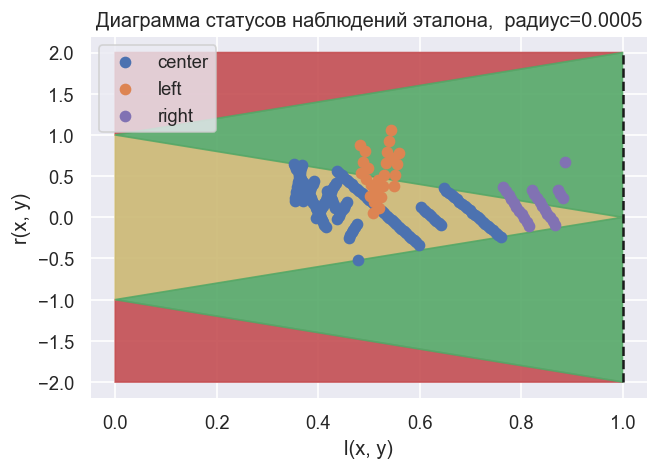

[3.230714, 3.230973]
Ширина: 0.000259
Частота: 200
Мера Жаккара: 0.1486
Зеленая зона: 170



In [54]:
# rads = np.arange(1e-4, 3 * 1e-4, 5 * 1e-4, 7 * 1e-4)
rad = np.float64(5e-4)
print(rad)
print(x)


bt = get_info((df2['мВ']- h_mnk2).tolist(), rad, x);

print("GG")

ost = plot_predict([(df2['мВ'] - rad - h_mnk2).tolist(), (df2['мВ'] + rad - h_mnk2).tolist()], bt, x, borders)
ost = np.array([ost[0][0] + ost[1][0] + ost[2][0], ost[0][1] + ost[1][1] + ost[2][1]])

r = ((df2['мВ'] - h_mnk2 - ost.mean(axis=0)) / rad).to_numpy()
l = (ost[1] - ost[0]) / 2 / rad


plt.title(f'Диаграмма статусов наблюдений эталона,  радиус={rad:.4f}')
plt.scatter(l[borders[1]: borders[2]], r[borders[1]: borders[2]], zorder=3, label='center')
plt.scatter(l[borders[0]: borders[1]], r[borders[0]: borders[1]], zorder=3, label='left')
plt.scatter(l[borders[2]: borders[3]], r[borders[2]: borders[3]], zorder=3, label='right', c='m')
axes = plt.gca()

axes.add_patch(mpl.patches.Polygon(np.array([[0, 0, max(1, l.max()+0.1)], [-2, -1, -2]]).T,
                                          color='r',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[0, 0, max(1, l.max()+0.1)], [2, 1, 2]]).T,
                                          color='r',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[0, 1, 0], [-1, 0, 1]]).T,
                                          color='y',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[max(1, l.max()+0.1), 0, 1, 0, max(1, l.max()+0.1)], 
                                             [-2, -1, 0, 1, 2]]
                                           ).T,
                                          color='g',
                                          alpha=0.9))

plt.plot([1, 1], [-2, 2], c='k', linestyle='--')

plt.xlabel('l(x, y)')
plt.ylabel('r(x, y)')
plt.legend()
plt.show()

jk = JK((df2['мВ'] + rad - h_mnk2).to_numpy(), (df2['мВ'] - rad - h_mnk2).to_numpy())
w = get_moda((df2['мВ'] + rad - h_mnk2).to_numpy(), (df2['мВ'] - rad - h_mnk2).to_numpy())

jks.append(jk)
ws.append(w)

print('Мера Жаккара: ' + "{:.4f}".format(jk))


print(f'Зеленая зона: {(np.abs(r) <= 1-l).sum()}')
print()

0.0006
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


  0%|          | 0/1200 [00:00<?, ?it/s]

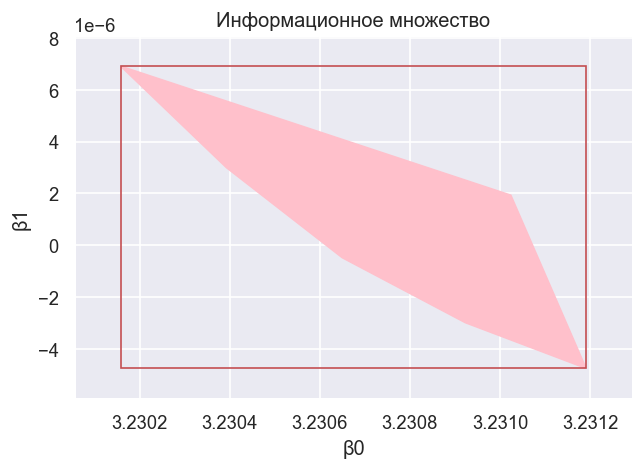

GG


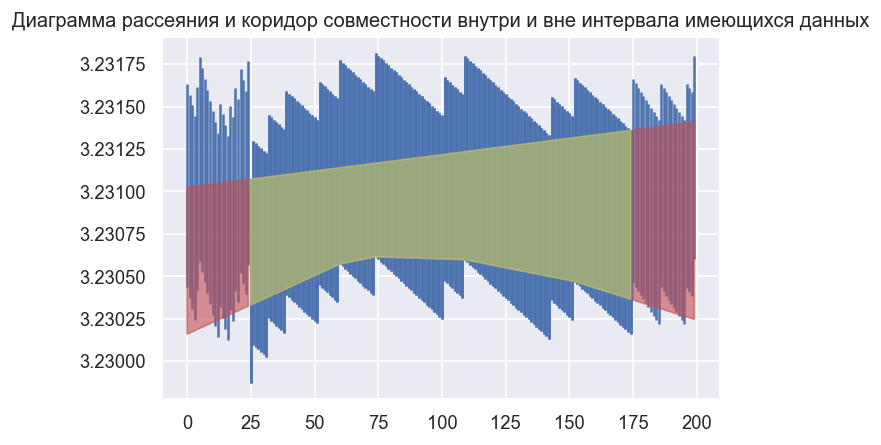

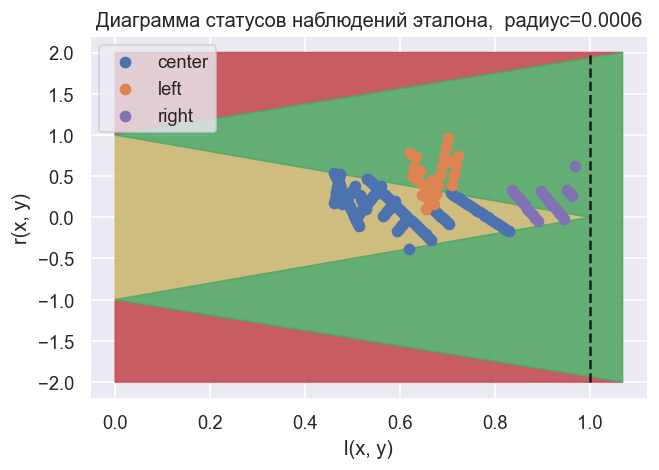

[3.230614, 3.231073]
Ширина: 0.000459
Частота: 200
Мера Жаккара: 0.2363
Зеленая зона: 162



In [55]:
# rads = np.arange(1e-4, 3 * 1e-4, 5 * 1e-4, 7 * 1e-4)
rad = np.float64(6e-4)
print(rad)
print(x)


bt = get_info((df2['мВ']- h_mnk2).tolist(), rad, x);

print("GG")

ost = plot_predict([(df2['мВ'] - rad - h_mnk2).tolist(), (df2['мВ'] + rad - h_mnk2).tolist()], bt, x, borders)
ost = np.array([ost[0][0] + ost[1][0] + ost[2][0], ost[0][1] + ost[1][1] + ost[2][1]])

r = ((df2['мВ'] - h_mnk2 - ost.mean(axis=0)) / rad).to_numpy()
l = (ost[1] - ost[0]) / 2 / rad


plt.title(f'Диаграмма статусов наблюдений эталона,  радиус={rad:.4f}')
plt.scatter(l[borders[1]: borders[2]], r[borders[1]: borders[2]], zorder=3, label='center')
plt.scatter(l[borders[0]: borders[1]], r[borders[0]: borders[1]], zorder=3, label='left')
plt.scatter(l[borders[2]: borders[3]], r[borders[2]: borders[3]], zorder=3, label='right', c='m')
axes = plt.gca()

axes.add_patch(mpl.patches.Polygon(np.array([[0, 0, max(1, l.max()+0.1)], [-2, -1, -2]]).T,
                                          color='r',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[0, 0, max(1, l.max()+0.1)], [2, 1, 2]]).T,
                                          color='r',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[0, 1, 0], [-1, 0, 1]]).T,
                                          color='y',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[max(1, l.max()+0.1), 0, 1, 0, max(1, l.max()+0.1)], 
                                             [-2, -1, 0, 1, 2]]
                                           ).T,
                                          color='g',
                                          alpha=0.9))

plt.plot([1, 1], [-2, 2], c='k', linestyle='--')

plt.xlabel('l(x, y)')
plt.ylabel('r(x, y)')
plt.legend()
plt.show()

jk = JK((df2['мВ'] + rad - h_mnk2).to_numpy(), (df2['мВ'] - rad - h_mnk2).to_numpy())
w = get_moda((df2['мВ'] + rad - h_mnk2).to_numpy(), (df2['мВ'] - rad - h_mnk2).to_numpy())

jks.append(jk)
ws.append(w)

print('Мера Жаккара: ' + "{:.4f}".format(jk))


print(f'Зеленая зона: {(np.abs(r) <= 1-l).sum()}')
print()

0.0007
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


  0%|          | 0/1401 [00:00<?, ?it/s]

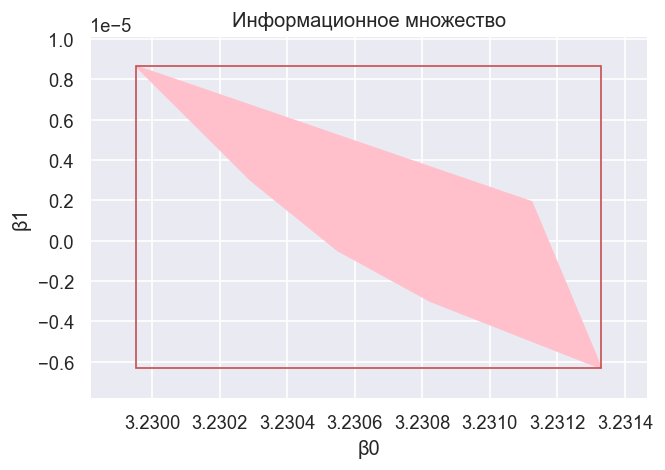

GG


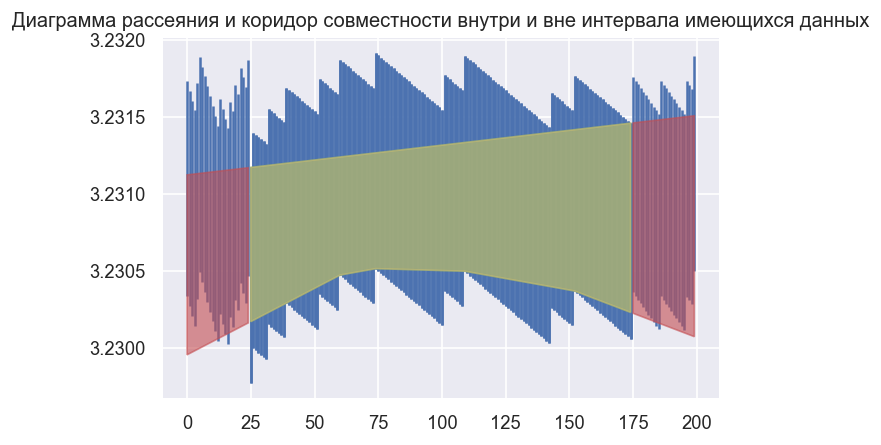

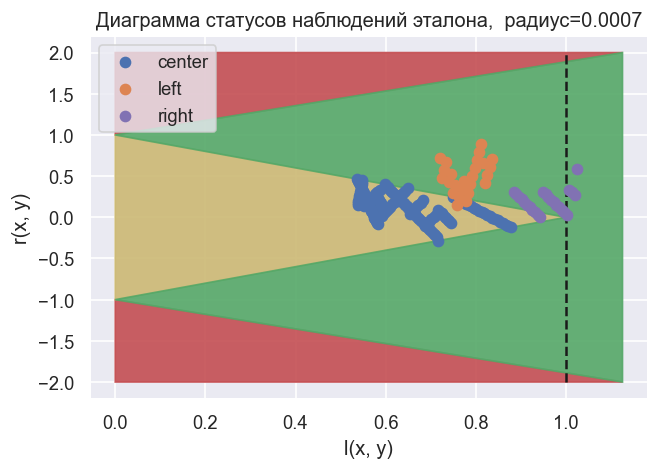

[3.230514, 3.231173]
Ширина: 0.000659
Частота: 200
Мера Жаккара: 0.3077
Зеленая зона: 152



In [56]:
# rads = np.arange(1e-4, 3 * 1e-4, 5 * 1e-4, 7 * 1e-4)
rad = np.float64(7e-4)
print(rad)
print(x)


bt = get_info((df2['мВ']- h_mnk2).tolist(), rad, x);

print("GG")

ost = plot_predict([(df2['мВ'] - rad - h_mnk2).tolist(), (df2['мВ'] + rad - h_mnk2).tolist()], bt, x, borders)
ost = np.array([ost[0][0] + ost[1][0] + ost[2][0], ost[0][1] + ost[1][1] + ost[2][1]])

r = ((df2['мВ'] - h_mnk2 - ost.mean(axis=0)) / rad).to_numpy()
l = (ost[1] - ost[0]) / 2 / rad


plt.title(f'Диаграмма статусов наблюдений эталона,  радиус={rad:.4f}')
plt.scatter(l[borders[1]: borders[2]], r[borders[1]: borders[2]], zorder=3, label='center')
plt.scatter(l[borders[0]: borders[1]], r[borders[0]: borders[1]], zorder=3, label='left')
plt.scatter(l[borders[2]: borders[3]], r[borders[2]: borders[3]], zorder=3, label='right', c='m')
axes = plt.gca()

axes.add_patch(mpl.patches.Polygon(np.array([[0, 0, max(1, l.max()+0.1)], [-2, -1, -2]]).T,
                                          color='r',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[0, 0, max(1, l.max()+0.1)], [2, 1, 2]]).T,
                                          color='r',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[0, 1, 0], [-1, 0, 1]]).T,
                                          color='y',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[max(1, l.max()+0.1), 0, 1, 0, max(1, l.max()+0.1)], 
                                             [-2, -1, 0, 1, 2]]
                                           ).T,
                                          color='g',
                                          alpha=0.9))

plt.plot([1, 1], [-2, 2], c='k', linestyle='--')

plt.xlabel('l(x, y)')
plt.ylabel('r(x, y)')
plt.legend()
plt.show()

jk = JK((df2['мВ'] + rad - h_mnk2).to_numpy(), (df2['мВ'] - rad - h_mnk2).to_numpy())
w = get_moda((df2['мВ'] + rad - h_mnk2).to_numpy(), (df2['мВ'] - rad - h_mnk2).to_numpy())

jks.append(jk)
ws.append(w)

print('Мера Жаккара: ' + "{:.4f}".format(jk))


print(f'Зеленая зона: {(np.abs(r) <= 1-l).sum()}')
print()

In [57]:
sup = np.array([4, 9, 4.5, 9])
inf = np.array([1, 5, 1.5, 6])

In [58]:
get_moda(sup, inf);

[1.5, 4.0]∪[6.0, 9.0]
Ширина: 5.5
Частота: 2


In [59]:
rads = np.array([4e-4, 5e-4, 6e-4, 7e-4])

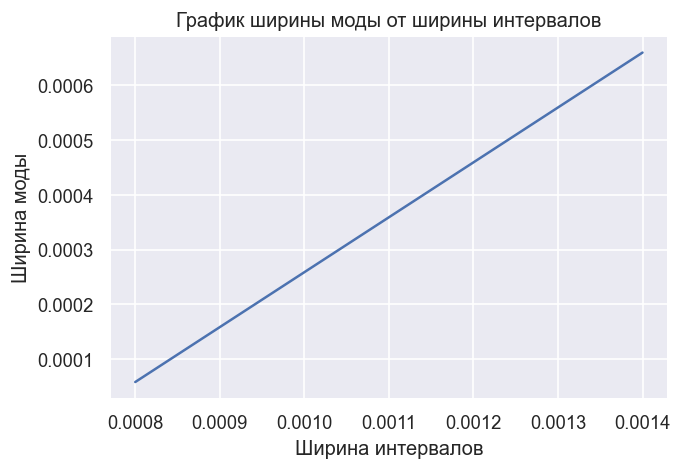

In [60]:
plt.title('График ширины моды от ширины интервалов')
plt.plot(rads*2, ws)
plt.xlabel('Ширина интервалов')
plt.ylabel('Ширина моды')
plt.show()

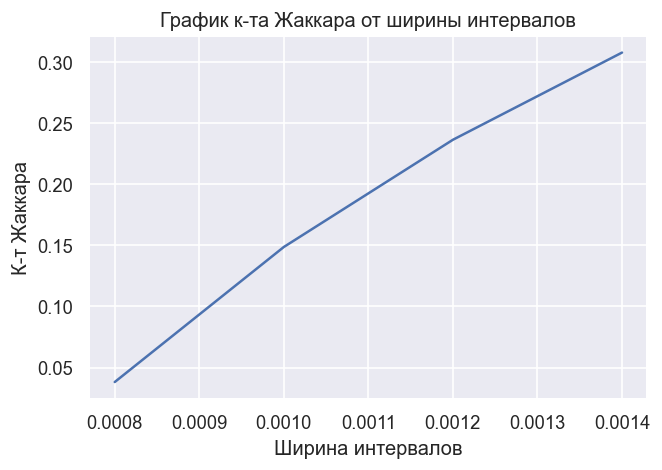

In [61]:
plt.title('График к-та Жаккара от ширины интервалов')
plt.plot(rads*2, jks)
plt.xlabel('Ширина интервалов')
plt.ylabel('К-т Жаккара')
plt.show()